# RHESSI (Reuven Ramaty High Energy Solar Spectroscopic Imager)
### Estudio de las llamaradas solares 
##### Descripcion:
Durante una llamarada, el gas situado en la atmósfera solar alcanza temperaturas de hasta 11 millones de grados Celsius, acelerando particulas a velocidades muy altas en el proceso. Esta aceleración ocasiona emisiones de luz en un rango que va desde el visible hasta rayos gamma, en donde dicha radiación no es apta para penetrar la atmósfera terrestre y por lo tanto no puede ser medida desde la tierra. Para poder registrar estas llamaradas y sus emisiones, se desarrolló la misión RHESSI mediante la creación de un satélite que midiera esta radiación y de esta manera lograr enteder el comportamiento de las llamaradas. El instrumento combina imagenes espectroscópicas del sol para caracterizar las energías presentes en cada llamarada. 

### Primer acercamiento con los datos
Para iniciar, se tomó la base de datos de la misión RHESSI de la NASA desde la página Kaggle [Solar Flares from RHESSI Mission](https://www.kaggle.com/datasets/khsamaha/solar-flares-rhessi) directamente como un archivo CSV. En esta página se encuentran 2 archivos referentes a los intervalos 2002-1016 y 2002-2018, pero en el estudio se considera el archivo con los datos completos (2002-2018).

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy import stats
import statsmodels.api as sm

# Se está trabajando en la rama testgh by @SOG


Para limpiar un poco la base de datos, se realiza una unión entre las columnas que contienen información acerca de la fecha y hora de inicio de la erupción, para generar una columna ***DateTime*** que luego se convierte en el index de los datos y descartar entonces la columna ***flare***. Luego, se crean nuevas columnas que guardan información como la energía promedio y la energía máxima a partir de ***energy.kev***, que facilitarán el ordenamiento de los datos cuando este se requiera. Además, como mecanismo de filtración, se crea una función la cual recibe un *DataFrame* y una lista que tiene como elementos las banderas que se quieren omitir de los datos, para retornar un *DataFrame* sin los eventos asociados a las banderas establecidas. Lo anterior con el objetivo de filtrar los datos para tomar solo los eventos asociados a procesos solares, cuando esto sea necesario. 

In [83]:
file_path = r"2002to2018.csv"  #2002to2016.csv
df = pd.read_csv(file_path)
# df = df.sort_values(by='duration.s', ascending=False).reset_index(drop=True)
# formatT = '%Y-%m-%d %H:%M:%S'

df['Datetime'] = pd.to_datetime(df['start.date'] +
                                ' ' + 
                                df['start.time'])
df = df.set_index(pd.DatetimeIndex(df['Datetime']))
# del df['flare']
del df['start.date']
del df['start.time']
del df['Datetime']

## CALCULO DE ENERGIAS

Emax = []
Eprom = []
for i in df['energy.kev']:
    result = re.findall(r'[\d\.\d]+', i)
    Emax.append(float(result[1]))
    Eprom.append((float(result[0]) + float(result[1]))/2)

df['Emax.kev'] = Emax
df['Eprom.kev'] = Eprom
df['log(duration.s)'] = np.log(df['duration.s'])
df['log(flare)'] = np.log(df['flare'])



def filtro(data, Lbanderas): # Filtro por bandera
    for bandera in Lbanderas: 
        ## filter
        data = data[data['flag.1'] != bandera]
        
        data = data[data['flag.2'] != bandera]

        data = data[data['flag.3'] != bandera]
        
        data = data[data['flag.4'] != bandera]

        values = data['flag.5'].values
        lfilter = [i for i in list(values[pd.notnull(values)]) if bandera in i]
        data = data[~data['flag.5'].isin(lfilter)]
            
    return data
# df['radioR'] = np.sqrt(df['x.pos.asec']**2 + df['y.pos.asec']**2)
df

,flare,peak,end,duration.s,peak.c/s,total.counts,energy.kev,x.pos.asec,y.pos.asec,radial,active.region.ar,flag.1,flag.2,flag.3,flag.4,flag.5,Emax.kev,Eprom.kev,log(duration.s),log(flare)
Datetime,,,,,,,,,,,,,,,,,,,,
2002-02-12 21:29:56,2021213,21:33:38,21:41:48,712,136,167304.0,12-25,592,-358,692,0,A1,P1,NaN,NaN,NaN,25.0,18.5,6.568078,14.519208
2002-02-12 21:44:08,2021228,21:45:06,21:48:56,288,7,9504.0,6-12,604,-341,694,9811,A1,P1,PE,Q1,NaN,12.0,9.0,5.662960,14.519216
2002-02-13 00:53:24,2021332,00:54:54,00:57:00,216,15,11448.0,6-12,-310,375,487,9825,A1,P1,NaN,NaN,NaN,12.0,9.0,5.375278,14.519267
2002-02-13 04:22:52,2021308,04:23:50,04:26:56,244,20,17400.0,12-25,-277,378,469,9822,A1,P1,NaN,NaN,NaN,25.0,18.5,5.497168,14.519255
2002-02-13 07:03:52,2021310,07:05:14,07:07:48,236,336,313392.0,25-50,-272,390,476,9825,A1,GS,P1,PE,Q2,50.0,37.5,5.463832,14.519256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-09 16:41:28,18020903,16:42:54,16:43:32,124,18,2888.0,6-12,-345,-38,347,2699,A0,DF,P1,PE,Q2,12.0,9.0,4.820282,16.707043
2018-02-09 18:15:56,18020904,18:17:26,18:17:40,104,16,1656.0,6-12,-268,-38,271,2699,A0,DF,P1,PE,Q2,12.0,9.0,4.644391,16.707043
2018-02-10 13:04:36,18021001,13:06:46,13:07:04,148,15,2224.0,6-12,-115,-38,121,2699,A0,DF,P1,PE,Q2,12.0,9.0,4.997212,16.707048


**Gráfica Q-Q** para la duración de la llamarada

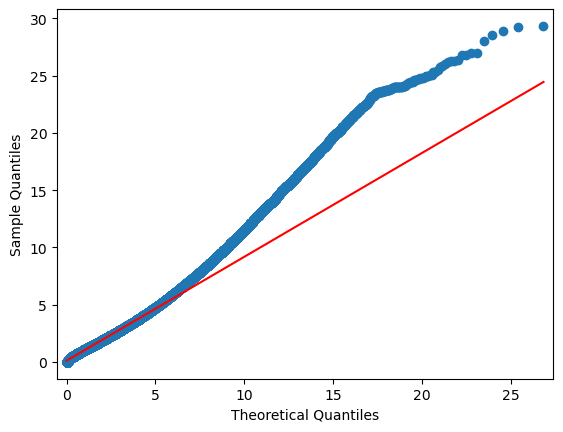

In [47]:
dfP = df[df['energy.kev'] == '12-25']
# sm.qqplot?

sm.qqplot(df['duration.s'], line='q', dist=stats.distributions.chi2, fit=True)
plt.show()

C:\Users\santi\AppData\Local\Temp\ipykernel_31132\2142362864.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfpos['x.pos.asec'] = np.abs(dfpos['x.pos.asec'])


(-200.0, 1250.0)

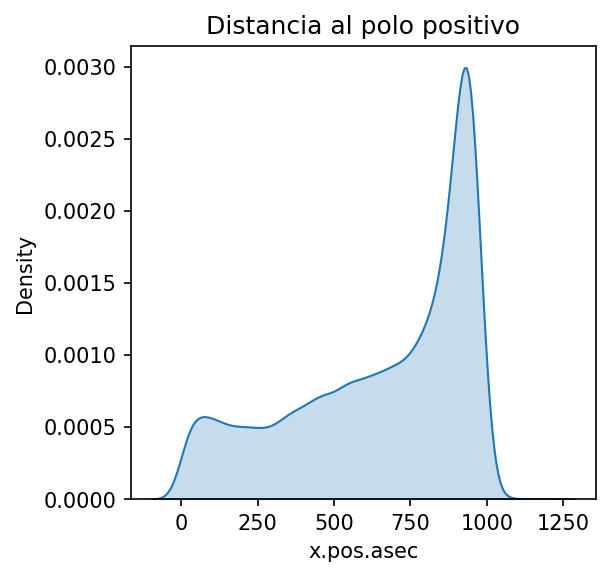

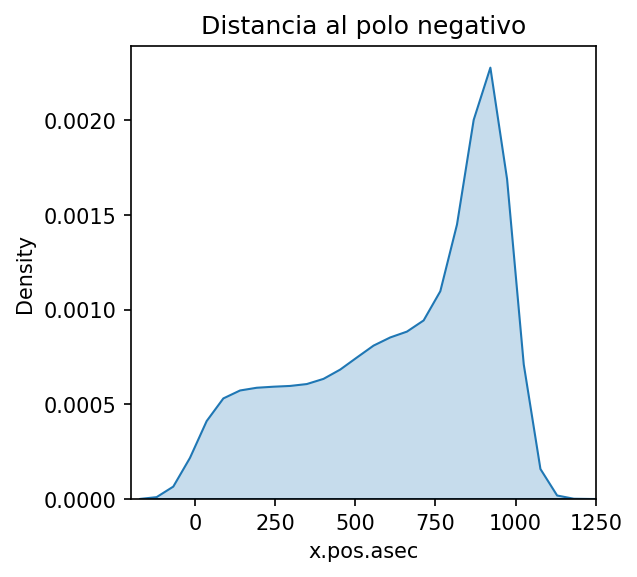

In [4]:
dfpos = df[df['x.pos.asec'] > 0]

plt.figure(figsize=(4,4), dpi = 150)
sns.kdeplot(data=dfpos.sort_values('Eprom.kev'), x='x.pos.asec',  fill=True)
plt.title('Distancia al polo positivo')

dfpos = df[df['x.pos.asec'] < 0]
dfpos['x.pos.asec'] = np.abs(dfpos['x.pos.asec'])

plt.figure(figsize=(4,4), dpi = 150)
sns.kdeplot(data=dfpos.sort_values('Eprom.kev'), x='x.pos.asec',  fill=True)
plt.title('Distancia al polo negativo')
plt.xlim(-200, 1250)

### Análisis primario de los datos
Como primer análisis a los datos, se busca estudiar si existe alguna relación lineal entre las columnas involucradas en la base de datos, y es por ello que se realiza una matriz de correlación. Esta matriz arroja como resultado un comportamiento no lineal y se descarta un estudio de este tipo para las columnas de la base de datos.

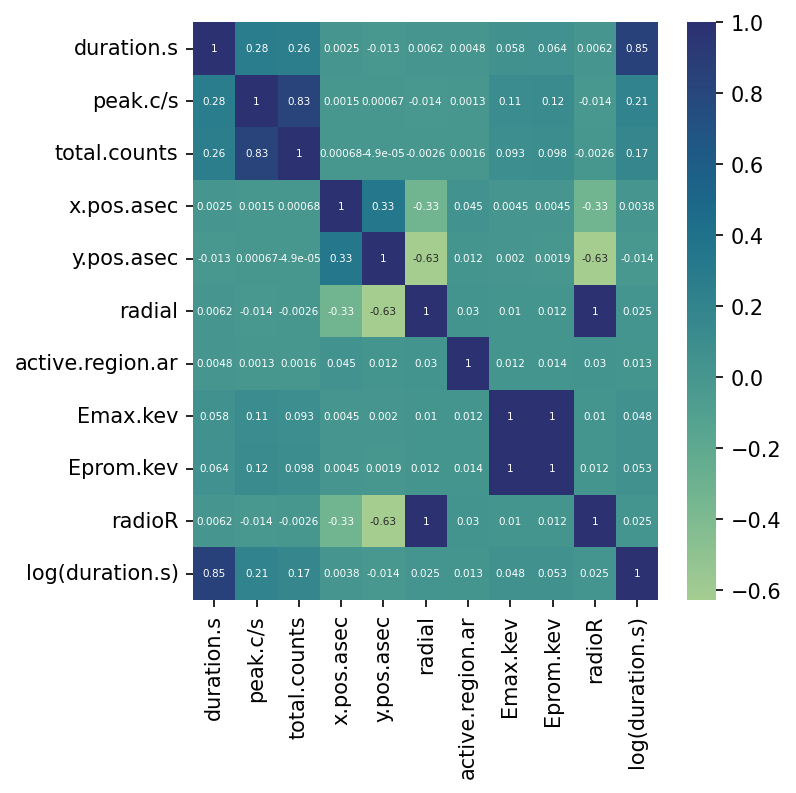

In [35]:
plt.figure(figsize=(5,5), dpi = 150)
matriz=df.corr(method='pearson')
sns.heatmap(matriz,cmap='crest',annot=True, annot_kws={'fontsize':5})
plt.savefig('img/matriz.png', dpi=300)

#### Histogramas
##### Se muestra la distribución de las erupciones en la superficie solar junto al histograma de la posición para cada ***(x,y)***
Con esta representación es posible ver como los eventos asociados a diferentes rangos de energía que ocurren en las capas exteriores de la atmósfera solar, son detectados por el satélite y como se distribuyen espacialmente. Se nota que eventos o llamaradas que emiten a una energía en el rango ultra-violeta (6-12 KeV) están distribuidos a través de toda la superficie solar, y que a medida que aumenta la energía emitida por las llamaradas, estas tienden a ubicarse justo en las zonas de mayor velocidad de rotación del sol.

In [ ]:
sns.jointplot(data=df.sort_values('Eprom.kev'), x='x.pos.asec', y='y.pos.asec', hue='energy.kev', kind='scatter', height=9, 
              xlim=(-1500, 1500), ylim=(-1500, 1500)).fig.suptitle('Flare distribution', fontsize=20)
plt.savefig('img/G1.png', dpi = 300)
print('ok')

También es posible notar que las distribuciones de las posiciones espaciales de las llamaradas siguen una distribución partiendo del origen hacia alguno de los polos, tal que es simetrica en relación al otro polo, dependiendo del eje espacial.

#### Histograma de rango de energías
##### Se muestra como se distribuyen los eventos en relación a su energía emitida 

In [ ]:
plt.figure(figsize=(5,5), dpi = 150)
plt.xticks(rotation=45)
sns.countplot(data=df.sort_values('Eprom.kev'), x="energy.kev", hue='energy.kev')

#### Diagrama de caja y bigotes
##### Se grafica un boxplot para los datos de la posición en **Y**
La utilización de este tipo de gráficos es muy importante ya que dan una pista de como se encuentran distribuidos los datos, y muestra datos outlayers.

In [ ]:
plt.figure(figsize=(4,4), dpi = 150)
sns.boxplot(data=df.sort_values('Eprom.kev'), x='energy.kev', y="y.pos.asec")
plt.xticks(rotation=45)
plt.title('Boxplot')

### Datos nulos y filtrado
##### Se filtran los posibles valores erróneos de acuerdo a las banderas establecidas en el archivo README, o eventos no ocurridos en el sol

De acuerdo a los intereses del estudio, se selecionaron los eventos que contienen banderas **NS**, **P0** o **PE**, ya que estos corresponden a eventos no solares, eventos con posición válida, o eventos de partículas solares. Lo anterior mediante el uso de la función *filtro* mencionada anteriormente. La filtración de estos datos es de suma importancia debido a que permite trabajar solamente con los datos provenientes de la superficie solar.

peak                    0
end                     0
duration.s              0
peak.c/s                0
total.counts            0
energy.kev              0
x.pos.asec              0
y.pos.asec              0
radial                  0
active.region.ar        0
flag.1                  0
flag.2                  0
flag.3              19907
flag.4              20202
flag.5              61180
Emax.kev                0
Eprom.kev               0
radioR                  0
log(duration.s)         0
dtype: int64

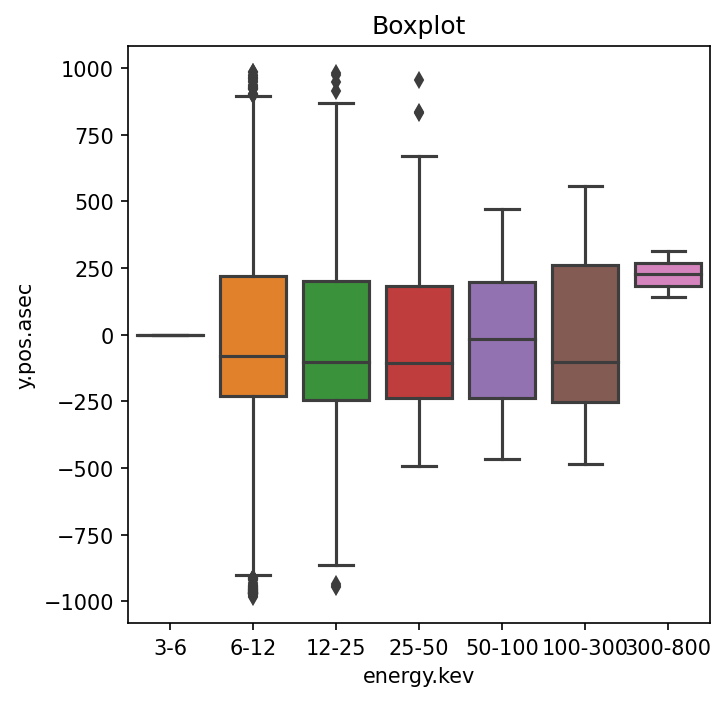

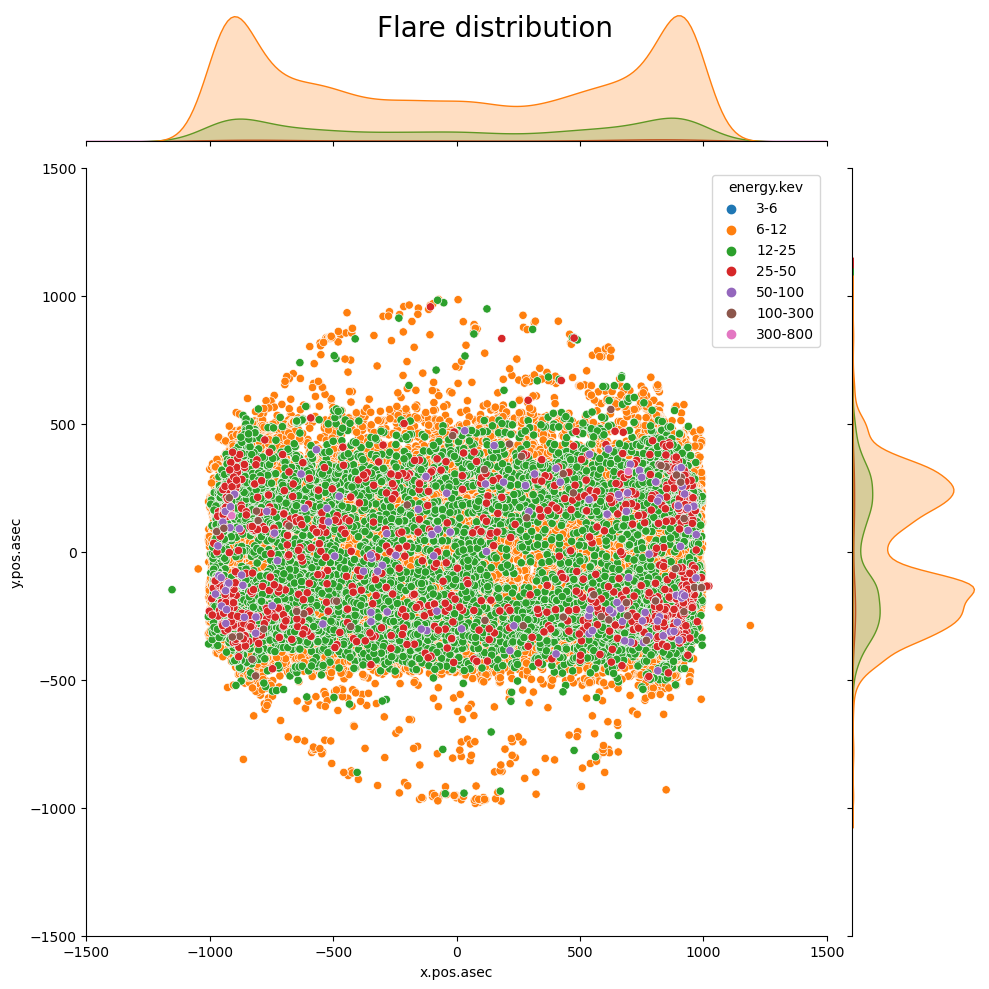

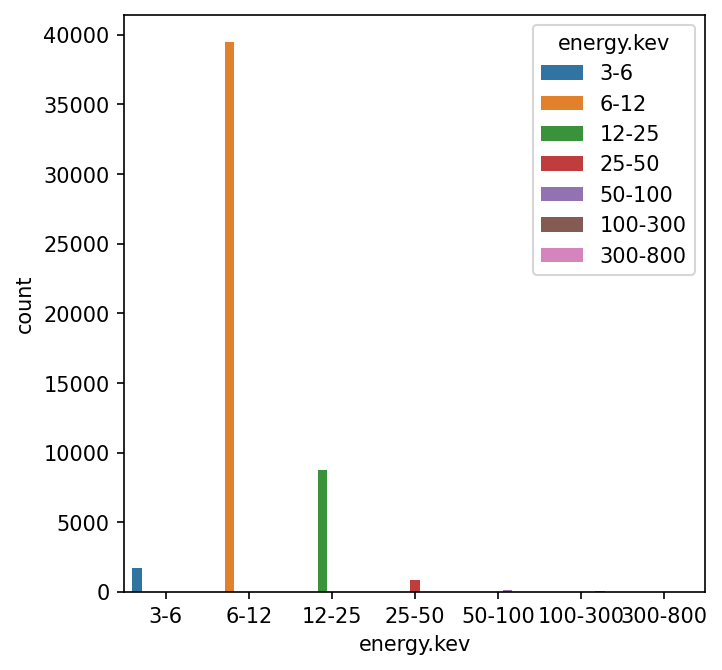

In [41]:
# lista = ['NS','SD','SS','SE','DF','DR','ED','EE','ES','FE','FR','FS','GD','GE','GS','MR','P0','PS','PE']
lista = ['NS', 'P0', 'PE']
dataFiltro = filtro(df, lista)
dataFiltro

# dataFiltro['duration.sl'] = np.log(dataFiltro['duration.s'])
# log(duration.s)

plt.figure(figsize=(5,5), dpi = 150)
sns.boxplot(data=dataFiltro.sort_values('Eprom.kev'), x='energy.kev', y="y.pos.asec")
plt.title('Boxplot')

sns.jointplot(data=dataFiltro.sort_values('Eprom.kev'), x='x.pos.asec', y='y.pos.asec', hue='energy.kev', kind='scatter', height=10, 
              xlim=(-1500, 1500), ylim=(-1500, 1500)).fig.suptitle('Flare distribution', fontsize=20)

plt.figure(figsize=(5,5), dpi = 150)
sns.countplot(data=dataFiltro.sort_values('Eprom.kev'), x="energy.kev", hue='energy.kev')

df.isnull().sum()

### Aproximación utilizando una distribución normal a partir de datos logarítmicos
Al estudiar la distribución de los datos relacionados a la duración de las llamaradas, se ve un comportamiento interesante que se busca estudiar más a fondo al llevar esta variable a una escala logarítmica.

In [ ]:
plt.figure(figsize=(4,4), dpi = 150)
sns.kdeplot(data=dataFiltro.sort_values('Eprom.kev'), x='duration.s', hue='energy.kev', fill=True)
plt.xlim(-50,3000)

Para implementar esta escala, es necesario crear una nueva columna que guarde el valor del logaritmo aplicada a la columna **duration.s**.

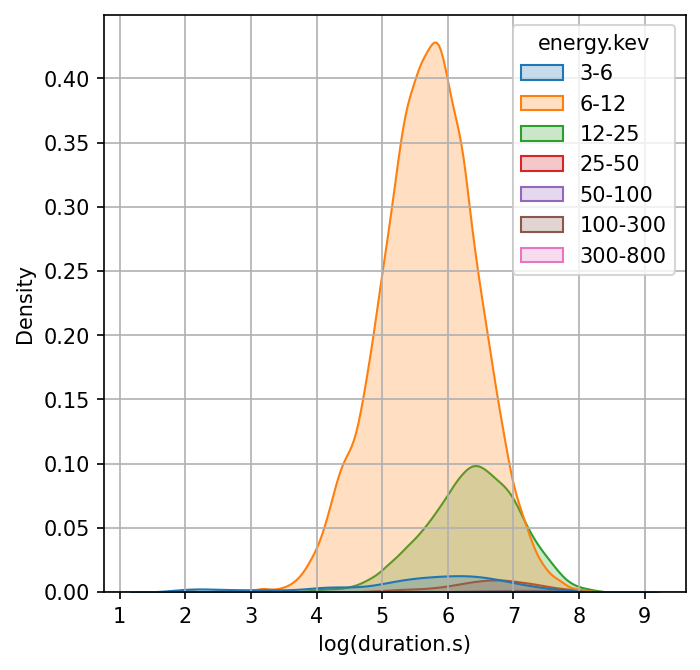

In [40]:
dataFiltro['log(duration.s)'] = np.log(dataFiltro['duration.s'])

plt.figure(figsize=(5,5), dpi = 150)
sns.kdeplot(data=dataFiltro.sort_values('Eprom.kev'), x='log(duration.s)', hue='energy.kev', fill=True)
plt.grid()

En esta escala logarítmica se evidencia un poco más el comportamiento normal que presentan los datos, y es por esto que se procede a realizar un ajuste para encontrar la función de distribución.

In [ ]:
distr = stats.norm

parametros = distr.fit(data=dataFiltro['log(duration.s)'])
# nombre_parametros = [p for p in inspect.signature(distr._pdf).parameters \
#                      if not p=='x'] + ["loc","scale"]
# parametros_dict = dict(zip(nombre_parametros, parametros))

x_hat = np.linspace(min(dataFiltro['log(duration.s)']), max(dataFiltro['log(duration.s)']), num=1000)
y_hat = distr.pdf(x_hat, *parametros)
plt.figure(figsize=(5,5), dpi = 150)
plt.plot(x_hat, y_hat, linewidth=2, label=distr.name)



# plt.figure(figsize=(5,5), dpi = 150)
sns.kdeplot(data=dataFiltro.sort_values('Eprom.kev'), x='log(duration.s)')
plt.legend()
plt.grid()
'Los parámetros son: ',parametros

De esta manera, se encuentra la distribución de densidad para la duración de llamaradas solares:

# $f(x) = \frac{1}{\sigma\cdot\sqrt{2\pi}}\cdot e^{-\frac{1}{2}(\frac{x-\mu}{\sigma})^2}$
#### donde $\mu \approx 5.8.21$ y $\sigma \approx 0.813$

Prueba QQ de la duración en comparación a una distribución chi cuadrada

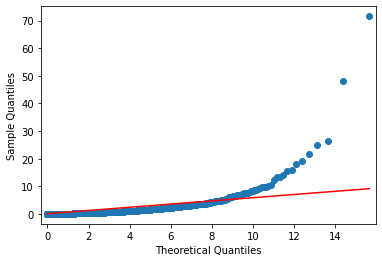

In [27]:
dfP = dataFiltro[dataFiltro['energy.kev'] != '50-100'] # Filtrar por energías si es necesario


# sm.qqplot?
sm.qqplot(dfP['total.counts'], line='s', dist=stats.distributions.chi2, fit=True)
plt.show()

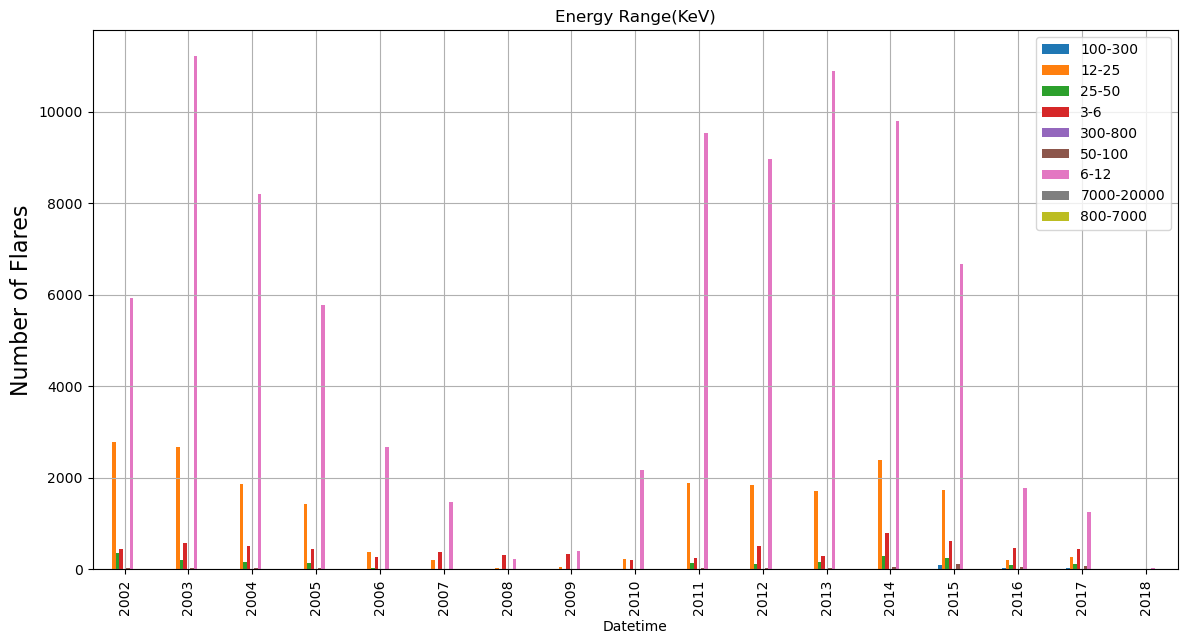

In [86]:
dataFiltro.loc['2002-02']

# plt.style.use('default')
df.groupby([df.index.year])['energy.kev'].value_counts().unstack().plot(kind='bar', figsize=(14,7), title='Energy Range(KeV)'
                                                                       , style='ggplot', grid=True)
plt.ylabel('Number of Flares', fontsize=16)
plt.legend(loc='best', prop={'size': 10})

In [95]:
dfpred = df.drop(['flag.1', 'flag.2', 'flag.3', 'flag.4', 'flag.5', 'log(flare)', 'end', 'peak', 'Emax.kev', 'Eprom.kev'], axis=1)
dfpred

,flare,duration.s,peak.c/s,total.counts,energy.kev,x.pos.asec,y.pos.asec,radial,active.region.ar,log(duration.s)
Datetime,,,,,,,,,,
2002-02-12 21:29:56,2021213,712,136,167304.0,12-25,592,-358,692,0,6.568078
2002-02-12 21:44:08,2021228,288,7,9504.0,6-12,604,-341,694,9811,5.662960
2002-02-13 00:53:24,2021332,216,15,11448.0,6-12,-310,375,487,9825,5.375278
2002-02-13 04:22:52,2021308,244,20,17400.0,12-25,-277,378,469,9822,5.497168
2002-02-13 07:03:52,2021310,236,336,313392.0,25-50,-272,390,476,9825,5.463832
...,...,...,...,...,...,...,...,...,...,...
2018-02-09 16:41:28,18020903,124,18,2888.0,6-12,-345,-38,347,2699,4.820282
2018-02-09 18:15:56,18020904,104,16,1656.0,6-12,-268,-38,271,2699,4.644391
2018-02-10 13:04:36,18021001,148,15,2224.0,6-12,-115,-38,121,2699,4.997212


In [96]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(dfpred, test_size=0.2)

# X_train.shape, X_test.shape

y_train = X_train['energy_kev']
X_train = X_train.drop(['energy_kev'], axis=1)

y_test = X_test['energy_kev']
X_test = X_test.drop(['energy_kev'], axis=1)

((92914, 10), (23229, 10))